# Simulation of random dataset sampling with replacements

Only for observational studies.

#### 1. Run the following scripts to import data and define `count_unique_genes()`.

In [1]:
import itertools
import pandas as pd
import pickle
import numpy as np
import time
from matplotlib import pyplot as plt
import re

In [2]:
merged = pd.read_csv("../../data/intermediate_data_02/merged.csv")
match_summary = pd.read_csv("../../data/intermediate_data_02/match_summary.csv")
match_summary["firstauthor_year"] = match_summary["first_author"] + "_"+match_summary["year"].astype(int).astype(str)
print(merged[:5])

        transcript_id  num_detected  num_sampled  proportion  \
0  Cre01.g000017.t1.1             0            2       0.000   
1  Cre01.g000033.t1.1             1            1       0.125   
2  Cre01.g000050.t1.1             0            1       0.000   
3  Cre01.g000100.t1.1             0            1       0.000   
4  Cre01.g000150.t1.2             1            1       0.125   

                           source annotation_version        gene_id  \
0  ['Bajhaiya_2016', 'Kwak_2017']               v5.5  Cre01.g000017   
1               ['Bajhaiya_2016']               v5.5  Cre01.g000033   
2               ['Gargouri_2015']               v5.5  Cre01.g000050   
3               ['Bajhaiya_2016']               v5.5  Cre01.g000100   
4               ['Bajhaiya_2016']               v5.5  Cre01.g000150   

  gene_symbol pathway_id  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4        ZRT2        NaN  


Pathway code

superpathway of fatty acid biosynthesis II (plant) = PWY-5156
Creinhardtii PWY-4381	fatty acid biosynthesis initiation I

Identifier: 	PWY-6799Name: 	fatty acid biosynthesis (plant mitochondria)

diacylglycerol and triacylglycerol biosynthesis = TRIGLSYN-PWY

In [3]:
def count_unique_genes(conditions, df):

    '''Takes in conditional statements to filter a dataframe. Return a dictionary with number of samples with replacements as key and the number of unique genes satisfying conditions and sampled by the samples as value.'''
    
    t0 = time.time()

    filtered = df[conditions]
    
    sample_dict = dict((key, []) for key in range(1,len(match_summary.firstauthor_year)))

    for i in range(1,len(match_summary.firstauthor_year)):
        for sample in itertools.combinations_with_replacement(match_summary.firstauthor_year, i):
        
            unique_sample = list(np.unique(sample))
            k = len(sample)
        
            count = 0
        
            for source in filtered.source:
            
            #if 'source' of a transcript contains sampled datasets,add 1 to count
                if any(i in source for i in unique_sample):
                    count+=1
                    continue
                    #print (source)
                else: pass
                
            #Add count to running dictionary
            sample_dict[k].append(count)
   
    t1 = time.time()   
    print(t1-t0, "s")
    return(sample_dict)

In [4]:
A = (merged.num_detected>=2)
B = (merged.num_sampled>=2)
C = merged.pathway_id.str.contains("TRIGLSYN-PWY")==True
D = merged.pathway_id.str.contains("PWY-4381")==True
F = (merged.num_detected>=1)

#### 2. Run one of the following cells depending on the conditions of interest

Each cell defines the condition(s) to filter the dataset that goes into `count_unique_genes()` and generates the corresponding cumulative unique gene plot. 

In [5]:
condition = (A & B)
filename = "simulations_output/strong_evidence.png"

In [6]:
condition = (F)
filename = "simulations_output/at_least_one_detected.png"

In [7]:
condition = ((C|D)&A)
filename = "simulations_output/lipid_pathway_at_least_one_detected.png"

In [8]:
condition = (C|D)
filename = "simulations_output/lipid_pathway.png"

#### 3. Run the cell below to generate the cumulative unique gene plot. 

0.44356703758239746 s


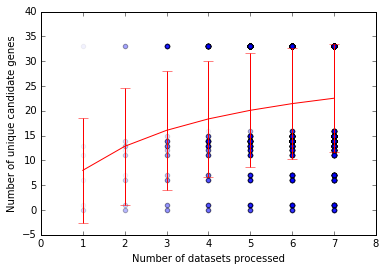

In [9]:
sample_dict = count_unique_genes(condition, merged)
num_datasets_plt =[]
num_genes = []
for k, v in sample_dict.items():
    num_datasets_plt.extend([k]*len(v))
    for e in v: num_genes.append(e)
#print(num_genes)
scatterplt = pd.DataFrame.from_dict({'num_datasets' : num_datasets_plt,
                                    'num_genes' : num_genes})

num_datasets = list(sample_dict.keys())
average = [np.mean(i) for i in sample_dict.values() ]
sd = [np.std(i) for i in sample_dict.values() ]

fig, ax = plt.subplots()

plt.scatter(x='num_datasets', y='num_genes', data = scatterplt, alpha = 0.05, zorder =2)
ax.errorbar(num_datasets, average,
       yerr=sd,
       alpha=1,
       color='red',
       capsize=5)
ax.set_xlabel('Number of datasets processed')
ax.set_ylabel('Number of unique candidate genes')
plt.savefig(filename, bbox_inches = "tight", dpi = 300)